# Import & summarize data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
train = pd.read_csv('../geotab-data/train.csv')
test = pd.read_csv('../geotab-data/test.csv')

In [3]:
print("Train dataset shape: "+ str(train.shape))
print("Test dataset shape:  "+ str(test.shape))

Train dataset shape: (857409, 28)
Test dataset shape:  (1920335, 13)


In [4]:
def summarize(df, quant=False):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['name'] = summary['index']
    summary = summary[['name','dtypes']]
    summary['missing'] = df.isnull().sum().values    
    summary['unique'] = df.nunique().values
    summary['first_val'] = df.loc[0].values
    summary['last_val'] = df.loc[len(df)-1].values
    if quant:
        summary['max'] = df.max().values
        summary['mean'] = df.mean().values
        summary['median'] = df.median().values
        summary['stdev'] = df.std().values
    for name in summary['name'].value_counts().index:
        summary.loc[summary['name'] == name, 'entropy'] = round(scipy.stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    return summary

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

def combine_df(df):
    combined = []
    for x in df:
        combined+=(list(df[x].values))
    return combined

<h1>Feature EDA</h1>

In [5]:
train_summary = summarize(train)
test_summary = summarize(test)

In [6]:
predictors = train_summary[12:27]
train_v_test = pd.merge(train_summary,test_summary, on='name',suffixes=('_train','_test'))
train_v_test[['name', 'dtypes_train', 'missing_train', 'missing_test','unique_train','unique_test',
       'first_val_train', 'first_val_test', 'last_val_train', 'last_val_test', 'entropy_train', 'entropy_test']]

,name,dtypes_train,missing_train,missing_test,unique_train,unique_test,first_val_train,first_val_test,last_val_train,last_val_test,entropy_train,entropy_test
0,RowId,int64,0,0,857409,1920335,1920335,0,2777743,1920334,19.71,20.87
1,IntersectionId,int64,0,0,2539,2768,0,1,1990,1990,10.63,10.85
2,Latitude,float64,0,0,4505,5613,33.7917,33.7509,39.9382,39.9382,11.41,11.84
3,Longitude,float64,0,0,4541,5614,-84.43,-84.393,-75.1499,-75.1499,11.43,11.86
4,EntryStreetName,object,8189,19157,1707,2136,Marietta Boulevard Northwest,Peachtree Street Southwest,South 4th Street,South 4th Street,8.97,9.19
5,ExitStreetName,object,5534,16340,1693,2117,Marietta Boulevard Northwest,Mitchell Street Southwest,South 4th Street,South 4th Street,8.95,9.17
6,EntryHeading,object,0,0,8,8,NW,SW,S,S,2.85,2.90
7,ExitHeading,object,0,0,8,8,NW,SE,S,S,2.85,2.90
8,Hour,int64,0,0,24,24,0,0,23,22,4.50,4.49
9,Weekend,int64,0,0,2,2,0,0,1,1,0.85,0.84


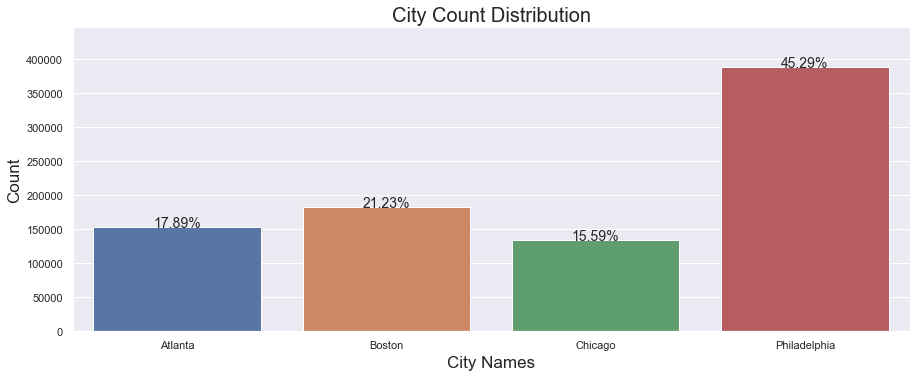

In [7]:
total = len(train)
plt.figure(figsize=(15,19))

plt.subplot(311)
g = sns.countplot(x="City", data=train)
g.set_title("City Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("City Names", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

<ul><li>highest is Philly</li><li>lowest is Chi</li></ul>

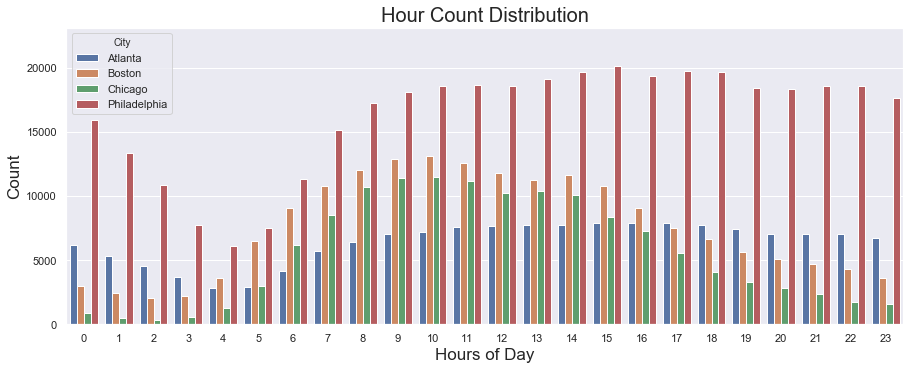

In [8]:
tmp_hour = train.groupby(['City', 'Hour'])['RowId'].nunique().reset_index()

plt.figure(figsize=(15,12))

plt.subplot(211)
g = sns.countplot(x="Hour", data=train, hue='City', dodge=True)
g.set_title("Hour Count Distribution", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Hours of Day", fontsize=17)
sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)
plt.show()

<ul><li>Philly consistently highesat hours, drops off between 1 and 6am</li>
    <li>Atlanta has a similar pattern, but lower overall</li>
    <li>Boston peaks most in the morning and slightly around 2pm</li>
    <li>Chicago follows a similar pattern but is lower overall</li></ul>

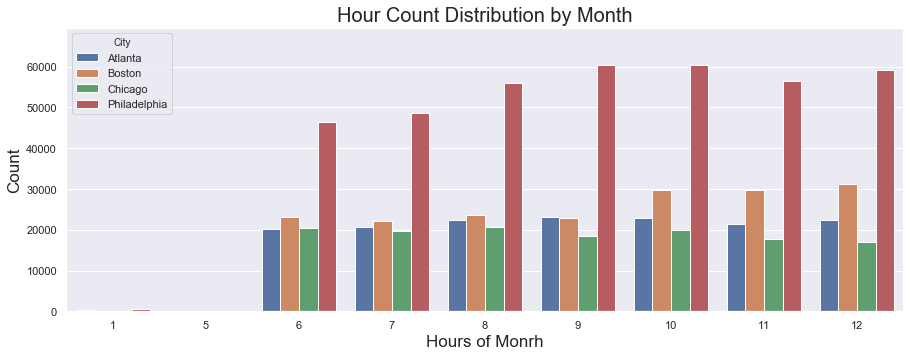

In [9]:
plt.figure(figsize=(15,12))

plt.subplot(212)
g1 = sns.countplot(x="Month", data=train, hue='City', dodge=True)
g1.set_title("Hour Count Distribution by Month", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Hours of Monrh", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

g1.set_ylim(0, max(sizes) * 1.15)

plt.subplots_adjust(hspace = 0.3)

plt.show()

<ul>
<li>only 7 months of data (June - December)</li>
<li>May and Jan exist also but barely any data</li>
<li>Boston steadily rises, rest stay pretty stable</li>
</ul>

In [10]:
percent_weekend = sum(train.Weekend)/len(train.Weekend)
percent_weekday = (1-percent_weekend)
print('Weekend Percent:\t',round(percent_weekend*100,2),
      '%',' (',round((2/7)*100,2),'%)',
      '\nWeekday Percent:\t',round(percent_weekday*100,2),
      '%',' (',round((5/7)*100,2),'%)')

Weekend Percent:	 27.75 %  ( 28.57 %) 
Weekday Percent:	 72.25 %  ( 71.43 %)


<ul>
<li>Percentage of weekend vs weekday data is pretty much as expected</li>
<li>Slightly higher weekday percent but doesn't seem significant</li>    
</ul>

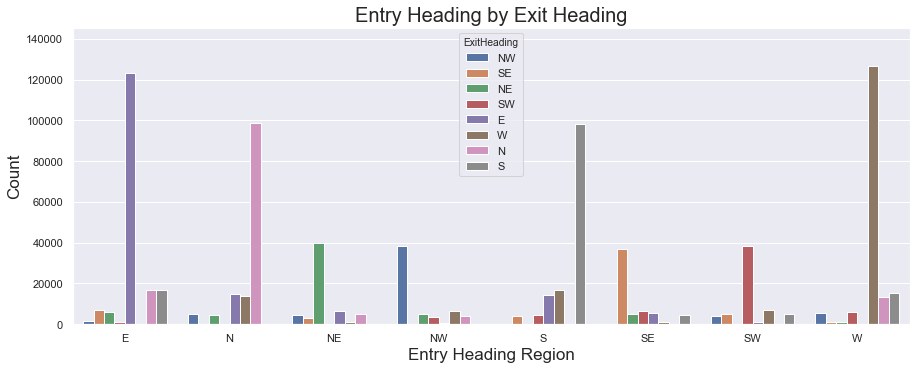

In [11]:
#need to explore entry exit street data
plt.figure(figsize=(15,12))

tmp = round(((train.groupby(['EntryHeading'])['RowId'].nunique() / total) * 100)).reset_index()

plt.subplot(211)
g = sns.countplot(x="EntryHeading",
                  data=train,
                  order=list(tmp['EntryHeading'].values),
                  hue='ExitHeading', dodge=True)
g.set_title("Entry Heading by Exit Heading", fontsize=20)
g.set_ylabel("Count",fontsize= 17)
g.set_xlabel("Entry Heading Region", fontsize=17)

sizes=[]
for p in g.patches:
    height = p.get_height()
    sizes.append(height)

g.set_ylim(0, max(sizes) * 1.15)
plt.show()

<ul>
<li>biggest take away from this is that most people go straight through intersections</li>
<li>it also seems there is higher travel east/west compared to north/south</li>
</ul>

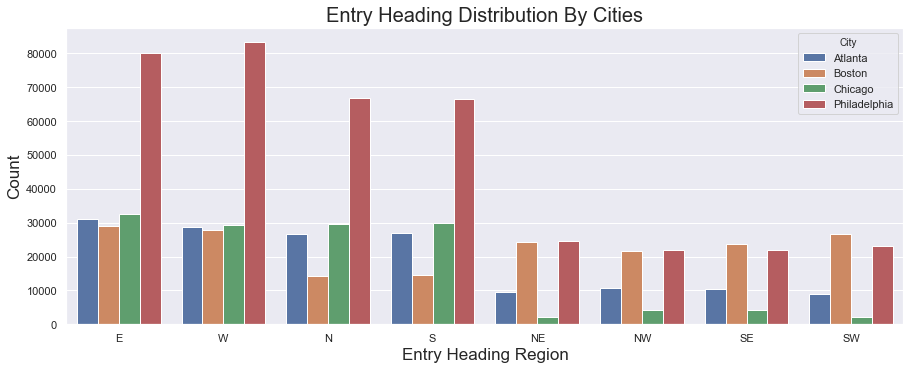

In [12]:
plt.figure(figsize=(15,12))
plt.subplot(212)
g1 = sns.countplot(x="EntryHeading", order=['E', 'W', 'N', 'S', 'NE', 'NW', 'SE', 'SW'], 
                   data=train, hue='City')
g1.set_title("Entry Heading Distribution By Cities", fontsize=20)
g1.set_ylabel("Count",fontsize= 17)
g1.set_xlabel("Entry Heading Region", fontsize=17)
sizes=[]
for p in g1.patches:
    height = p.get_height()
    sizes.append(height)

<ul>
    <li>direction by city shows similar finds as above although some differences</li>
    <li>chicago and atlanta seem pretty evenly distributed across the main directions</li>
    <li>philly and boston are more heavily east/west than north/south cities</li>
    <li>phillh and boston also have much more secondary direction travel compared to atlanta and chicago</li>
</ul>

<h1>Target EDA</h1>

In [13]:
targets = train.iloc[:,12:27]
summarize(targets,True).drop(['first_val','last_val'], axis =1)

,name,dtypes,missing,unique,max,mean,median,stdev,entropy
0,TotalTimeStopped_p20,int64,0,172,273.0,1.731272,0.0,7.080017,0.92
1,TotalTimeStopped_p40,int64,0,234,318.0,5.356027,0.0,12.861420,2.11
2,TotalTimeStopped_p50,int64,0,264,343.0,7.681874,0.0,15.553418,2.70
3,TotalTimeStopped_p60,int64,0,311,368.0,11.905296,0.0,19.631821,3.55
4,TotalTimeStopped_p80,int64,0,403,689.0,22.948071,16.0,28.118134,5.06
5,TimeFromFirstStop_p20,int64,0,239,334.0,3.126932,0.0,11.631092,0.98
6,TimeFromFirstStop_p40,int64,0,306,347.0,9.051338,0.0,20.120829,2.25
7,TimeFromFirstStop_p50,int64,0,329,355.0,12.613628,0.0,23.847749,2.87
8,TimeFromFirstStop_p60,int64,0,351,358.0,18.801785,0.0,29.399634,3.77
9,TimeFromFirstStop_p80,int64,0,355,359.0,34.037097,27.0,40.619387,5.35


In [14]:
#split up for individual distrivution analysis
total_time = targets[['TotalTimeStopped_p20','TotalTimeStopped_p50', 'TotalTimeStopped_p80']]
time_from_first = targets[['TimeFromFirstStop_p20','TimeFromFirstStop_p50','TimeFromFirstStop_p80']]
distance_to_first = targets[['DistanceToFirstStop_p20','DistanceToFirstStop_p50','DistanceToFirstStop_p80']]

In [15]:
#combine distribution data into a single array
tt_all = combine_df(total_time)
tff_all = combine_df(time_from_first)
dtf_all = combine_df(distance_to_first)

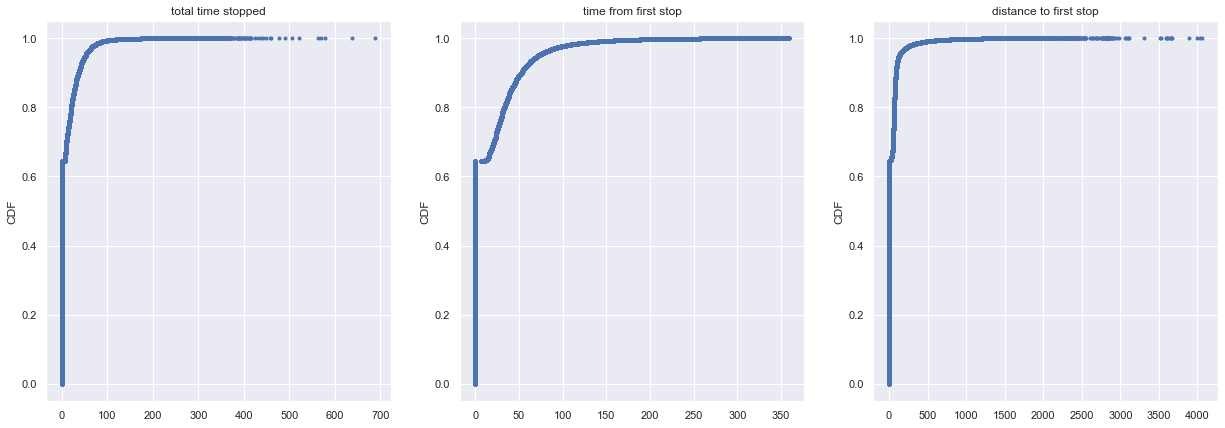

In [16]:
plt.figure(figsize=(21,7))

#tts
x,y=ecdf(tt_all)
plt.subplot(1,3,1)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('total time stopped')
plt.ylabel('CDF')

#tffs
x,y=ecdf(tff_all)
plt.subplot(1,3,2)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('time from first stop')
plt.ylabel('CDF')

#dfs
x,y=ecdf(dtf_all)
plt.subplot(1,3,3)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('distance to first stop')
plt.ylabel('CDF')

plt.show()

<ul>
    <li>distributions of combined data, shows similarity between total time stopeed and distance</li>
</ul>

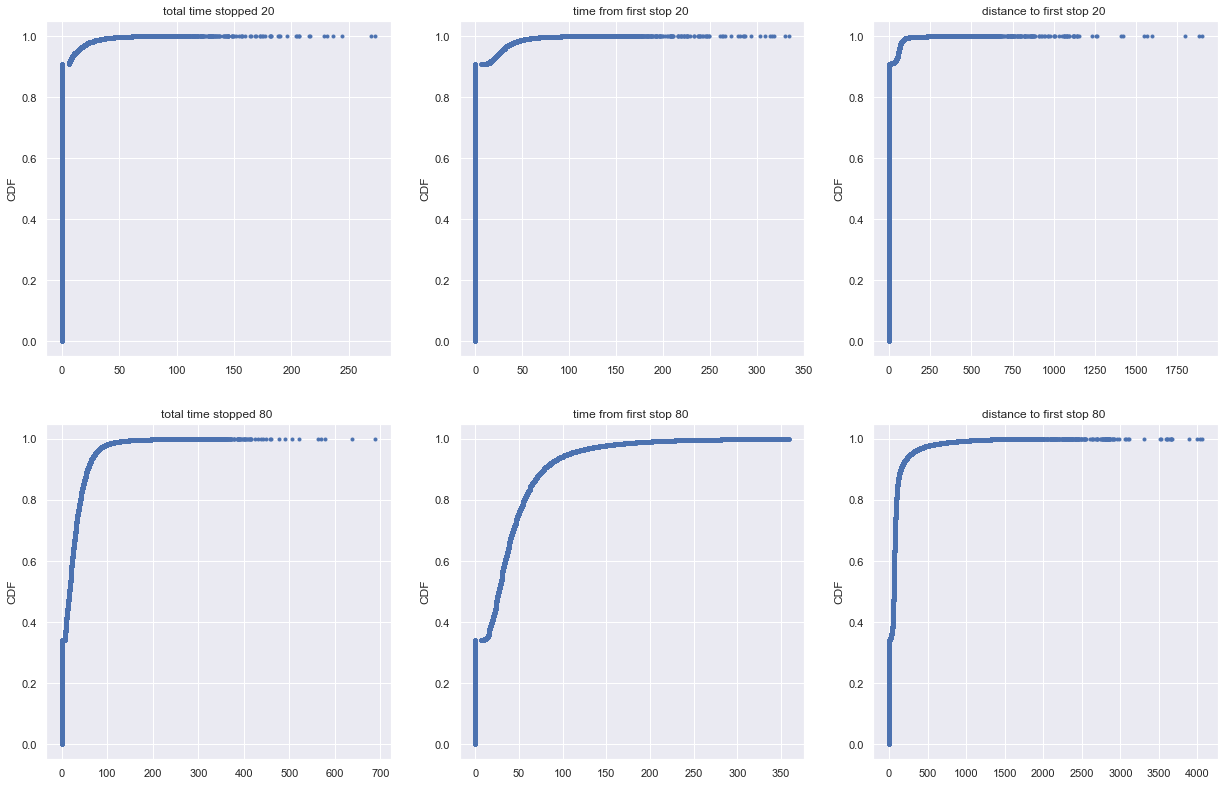

In [17]:
plt.figure(figsize=(21,21))

#tts
x,y=ecdf(total_time.TotalTimeStopped_p20)
plt.subplot(3,3,1)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('total time stopped 20')
plt.ylabel('CDF')

#tffs
x,y=ecdf(time_from_first.TimeFromFirstStop_p20)
plt.subplot(3,3,2)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('time from first stop 20 ')
plt.ylabel('CDF')

#dfs
x,y=ecdf(distance_to_first.DistanceToFirstStop_p20)
plt.subplot(3,3,3)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('distance to first stop 20 ')
plt.ylabel('CDF')

######################################################################
#tts
x,y=ecdf(total_time.TotalTimeStopped_p80)
plt.subplot(3,3,4)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('total time stopped 80 ')
plt.ylabel('CDF')

#tffs
x,y=ecdf(time_from_first.TimeFromFirstStop_p80)
plt.subplot(3,3,5)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('time from first stop 80 ')
plt.ylabel('CDF')

#dfs
x,y=ecdf(distance_to_first.DistanceToFirstStop_p80)
plt.subplot(3,3,6)
plt.plot(x,y,linestyle='none', marker='.')
plt.title('distance to first stop 80 ')
plt.ylabel('CDF')

######################################################################
# #tts
# x,y=ecdf(tt_all)
# plt.subplot(3,3,7)
# plt.plot(x,y,linestyle='none', marker='.')
# plt.title('total time stopped')
# plt.ylabel('CDF')

# #tffs
# x,y=ecdf(tff_all)
# plt.subplot(3,3,8)
# plt.plot(x,y,linestyle='none', marker='.')
# plt.title('time from first stop')
# plt.ylabel('CDF')

# #dfs
# x,y=ecdf(dtf_all)
# plt.subplot(3,3,9)
# plt.plot(x,y,linestyle='none', marker='.')
# plt.title('distance to first stop')
# plt.ylabel('CDF')

plt.show()

<ul>
    <li>time from first and distance to first more similar at p20</li>
    <li>total time stopped similar at p80</li>
</ul>

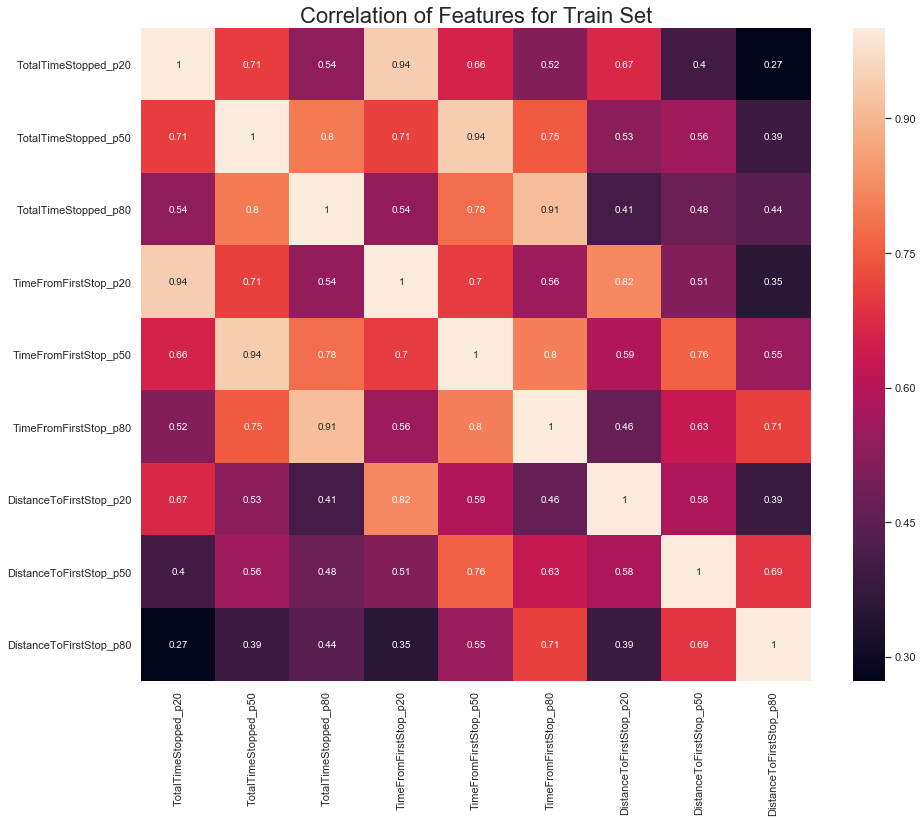

In [22]:
# Checking correlations for metric percentiles
plt.figure(figsize=(15,12))
sns.heatmap(train[list(total_time.columns) + 
                  list(time_from_first.columns) + 
                  list(distance_to_first.columns)].astype(float).corr(),
                  vmax=1.0,  annot=True)
plt.title('Correlation of Features for Train Set', fontsize=22)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

<ul>
    <li>time from first and distance to first more similar at p20</li>
    <li>total time stopped similar at p80</li>
</ul>